In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import copy
from torchsummary import summary
from sklearn.decomposition import PCA 
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
if torch.cuda.is_available():
    print("CUDA is available. You can run your code on GPU!")
else:
    print("CUDA is not available. Running on CPU instead.")

CUDA is available. You can run your code on GPU!


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
batch_size = 1024

trainset = torchvision.datasets.MNIST('data', train = True, download = True, transform = transforms.Compose([transforms.ToTensor()]))
train_loader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle=True)

testset = torchvision.datasets.MNIST('data', train = False, download = True, transform = transforms.Compose([transforms.ToTensor()]))
test_loader = torch.utils.data.DataLoader(testset ,batch_size = batch_size, shuffle=True)

In [5]:
class Model (nn.Module):
    def __init__(self):
        super().__init__()
        self.fcy1 = nn.Linear(784, 64)
        self.fcy2 = nn.Linear(64, 16)
        self.fcy3 = nn.Linear(16, 10)

    def forward(self, x):
        x = nn.functional.relu(self.fcy1(x))
        x = nn.functional.relu(self.fcy2(x))
        x = self.fcy3(x)
        return x

model_batch1 = Model()
model_batch2 = Model()
model_lr1 = Model()
model_lr2 = Model()

In [6]:
def evaluate_test_loss(dataloader, model): 
    loss_fn = nn.CrossEntropyLoss()
    
    model.eval()
    
    # train and store epoch training loss
    epoch_test_loss = 0.0
    for batch, (X_test, y_test) in enumerate(dataloader): 
        X_test = X_test.to(device).reshape(-1, 28*28)
        y_test = y_test.to(device)

        # compute model predictions and loss
        y_pred = model(X_test)
        loss = loss_fn(y_pred, y_test)

        # update epoch loss with batch loss (epoch loss := mean batch loss throughout all batches)
        epoch_test_loss += loss.item() / len(dataloader)
    
    # return epoch loss
    return epoch_test_loss

In [7]:
def params_count(model):
    return sum(params.numel() for params in model.parameters() if params.requires_grad)

def test_test_data(model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images,labels = data
            images, labels = images.to(device).reshape(-1, 28*28), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data,dim=1)      
            total += labels.size(0)
            correct += (predicted==labels).sum().item()
            
    return correct/total

def test_train_data(model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in train_loader:
            images,labels = data
            images, labels = images.to(device).reshape(-1, 28*28), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data,dim=1)      
            total += labels.size(0)
            correct += (predicted==labels).sum().item()
            
    return correct/total

In [8]:
learning_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
training_loss_data=[]
test_loss_data=[]
training_accuracy_data=[]
test_accuracy_data=[]
sensitivity_data=[]


for lr in learning_rates:  

    train_accuracies=[]
    test_accuracies=[]
    train_losses=[]
    test_losses=[]
    sensitivities=[]

    model = Model().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    

    for epoch in tqdm(range(40), desc=f'Epoch Progress (LR={lr})', leave=False):
        

        epoch_sensitivity = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device).reshape(-1, 28*28)
            labels = labels.to(device)

            # forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # backward and optimize
            optimizer.zero_grad()
        

            grads_p = torch.autograd.grad(loss, model.parameters(), create_graph=True)[0]
            epoch_sensitivity += grads_p.norm(2).detach().cpu().item() / len(train_loader)

            loss.backward()
            optimizer.step()
           
        # evaluate loss on test set
        test_loss = evaluate_test_loss(test_loader, model)
        training_loss = evaluate_test_loss(train_loader, model)
        
        # evaluate accuracy on train set
        train_accuracy = test_train_data(model)
        
        # evaluate accuracy on test set
        test_accuracy = test_test_data(model)

        # store epoch stats
        train_losses.append(training_loss)
        train_accuracies.append(train_accuracy)
        sensitivities.append(epoch_sensitivity)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
    
    # store mean values for current model
    test_loss_data.append(np.mean(test_losses))
    test_accuracy_data.append(np.mean(test_accuracies))
    training_loss_data.append(np.mean(train_losses))
    training_accuracy_data.append(np.mean(train_accuracies))
    sensitivity_data.append(np.mean(sensitivities))

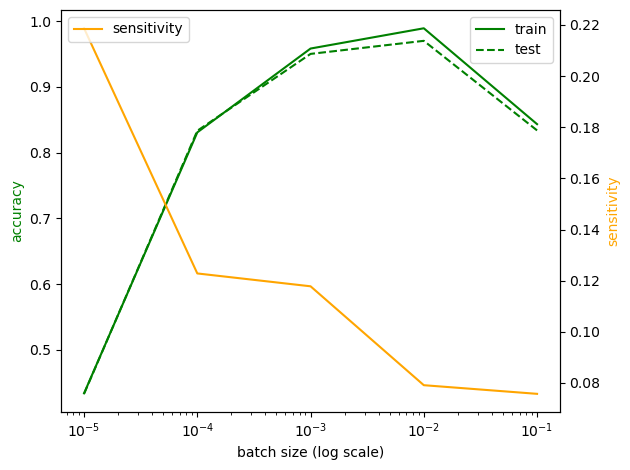

In [22]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('batch size (log scale)')
ax1.set_xscale('log')
ax1.set_ylabel('accuracy', color='green')
ax1.plot(learning_rates, training_accuracy_data, color='green', label="train")
ax1.plot(learning_rates, test_accuracy_data, '--', color='green', label="test")

ax1.legend()
ax2 = ax1.twinx()
ax2.set_ylabel('sensitivity', color='orange')
ax2.plot(learning_rates, sensitivity_data, color='orange', label="sensitivity")
plt.legend(loc='upper left')
fig.tight_layout()
plt.show()

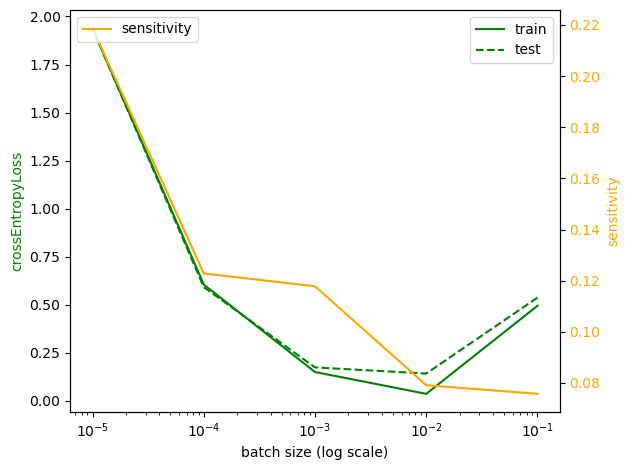

In [23]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('batch size (log scale)')
ax1.set_xscale('log')
ax1.set_ylabel('crossEntropyLoss', color='green')
ax1.plot(learning_rates, training_loss_data, color='green', label="train")
ax1.plot(learning_rates, test_loss_data, '--', color='green', label="test")
ax1.legend()
ax2 = ax1.twinx()
ax2.set_ylabel('sensitivity', color='orange')
ax2.plot(learning_rates,sensitivity_data,color='orange',label="sensitivity")
ax2.tick_params(axis='y', labelcolor='orange')
plt.legend(loc='upper left')
fig.tight_layout()
plt.show()